In [1]:
import spacy
import string
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score

Using TensorFlow backend.


In [2]:
data = pd.read_csv('H:/Learnings/Data Science/Hackathon/Amazon Review/Review_Data.csv',usecols=['reviews.rating', 'reviews.text'])

In [3]:
data.head()

,reviews.rating,reviews.text
0,3,I order 3 of them and one of the item is bad q...
1,4,Bulk is always the less expensive way to go fo...
2,5,Well they are not Duracell but for the price i...
3,5,Seem to work as well as name brand batteries a...
4,5,These batteries are very long lasting the pric...


In [4]:
data_1 = data.copy()

#### Let's check the ratings distribution

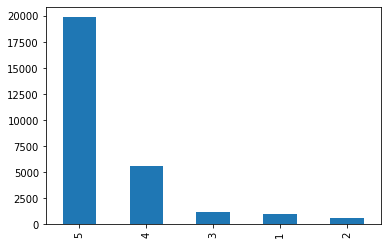

In [7]:
data_1['reviews.rating'].value_counts().plot(kind='bar')

#### Let's change the header names for easy understanding

In [8]:
data_1.rename(columns={'reviews.rating': 'Review', 'reviews.text': 'Sentiment'},inplace=True)

In [9]:
data_1.head()

,Review,Sentiment
0,3,I order 3 of them and one of the item is bad q...
1,4,Bulk is always the less expensive way to go fo...
2,5,Well they are not Duracell but for the price i...
3,5,Seem to work as well as name brand batteries a...
4,5,These batteries are very long lasting the pric...


#### Let's consider 4/5 values as good rating(1) and other values as bad rating(0) for Review column

In [10]:
data_1['Review'] = data_1['Review'].apply(lambda Review: 1 if Review == 4 else 1 if Review == 5 else 0)

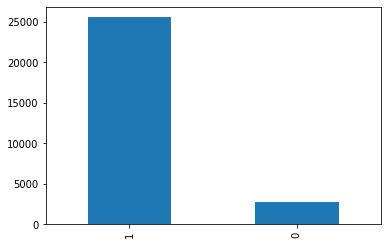

In [11]:
data_1['Review'].value_counts().plot(kind= 'bar')

In [12]:
data_1['Review'].value_counts()

1    25545
0     2787
Name: Review, dtype: int64

#### Checking Null values

In [13]:
data_1.isnull().sum()

Review       0
Sentiment    0
dtype: int64

### Tokenization

In [14]:
nlp = spacy.load('en_core_web_md')

In [15]:
stopwords = list(STOP_WORDS)

In [16]:
pun = string.punctuation

In [17]:
def data_clean(sentence):
    doc = nlp(sentence)
    tokens = []
    clean_tokens = []
    
    for token in doc:
        if token.lemma_ != '-PRON-':           
            temp = token.lemma_.lower().strip()                    
        else:            
            temp = token.lower_            
        tokens.append(temp)          
    
    for token in tokens:         
        if token not in stopwords and token not in pun:
            clean_tokens.append(token)
            
    return clean_tokens            

In [18]:
data_1['Sentiment'][10]

"I find amazon basics batteries to be equal if not superior to name brand ones. Can't believe I didn't start buying them sooner! The packages are large and the price is great too."

#### Let's remove the quotes from the sentences

In [19]:
data_1['Sentiment'] = data_1['Sentiment'].str.replace(r'[\'\",]*', '')

In [20]:
data_1['Sentiment'][10]

'I find amazon basics batteries to be equal if not superior to name brand ones. Cant believe I didnt start buying them sooner! The packages are large and the price is great too.'

In [21]:
data_clean('I find amazon basics batteries to be equal if not superior to name brand ones. Cant believe I didnt start buying them sooner! The packages are large and the price is great too.')

['find',
 'amazon',
 'basics',
 'battery',
 'equal',
 'superior',
 'brand',
 'believe',
 'start',
 'buy',
 'soon',
 'package',
 'large',
 'price',
 'great']

### TF-IDF

In [22]:
tfidf = TfidfVectorizer(tokenizer=data_clean)

In [23]:
x = data_1['Sentiment']
y = data_1['Review']

#### The data is highly imbalanced as negative reviews as only 9% of the total review. let's apply SMOTE.

In [49]:
smt = SMOTE(k_neighbors=1,random_state=124)
classifier = XGBClassifier()
pipeline = Pipeline([('tfidf', tfidf), ('smote', smt), ('clf', classifier)])

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
score={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
params = {'clf__max_depth':range(3,10,2),
          'clf__min_child_weight':range(1,6,2) }
gcv = GridSearchCV(estimator=pipeline, param_grid=params, cv=5,scoring= score, n_jobs=12,return_train_score=True,refit = 'AUC')

In [55]:
gcv.fit(x,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [56]:
gcv.best_params_

{'clf__max_depth': 3, 'clf__min_child_weight': 1}

In [57]:
gcv.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                        

In [ ]:
#y_train.value_counts()
#y_test.value_counts()
#pipeline1.fit(x_train, y_train)
#y_pred = pipeline1.predict(x_test)

#### let's input the best parameters to XGBOOST  Classifier

In [59]:
classifier = XGBClassifier(clf__max_depth =3,clf__min_child_weight=1)

In [60]:
pipeline.fit(x,y)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                        

#### let's try some review examples to check the sentiment of the customer

In [61]:
pipeline.predict(['I find amazon basics batteries to be equal if not superior to name brand ones. Cant believe I didnt start buying them sooner! The packages are large and the price is great too.'])

array([1], dtype=int64)

In [62]:
pipeline.predict(['the batteries are not working'])

array([0], dtype=int64)

In [63]:
pipeline.predict(['it is a dumb product. wothless'])

array([0], dtype=int64)

In [64]:
pipeline.predict(['Not worthy of money'])

array([0], dtype=int64)

In [65]:
pipeline.predict(['Useless product. was expecting a product with better features'])

array([0], dtype=int64)